In [24]:
import yaml

def load_config(config_path):
    with open(config_path, "r") as f:
        return yaml.safe_load(f)

config_path = "audioldm/ciap/configs/ciap_config.yaml"
config = load_config(config_path)

In [25]:
from audioldm import build_model

# Load LDM model
ldm_ckpt_path = "./ckpt/audioldm-s-full.ckpt"
audioldm = build_model(ckpt_path=ldm_ckpt_path)

Load AudioLDM: %s audioldm-s-full
DiffusionWrapper has 185.04 M params.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu
Loaded /Users/luffy_sama/Desktop/Workspace/IE_643/AudioLDM/ckpt/ciap_image_encoder_epoch110.pt: missing_keys=0, unexpected_keys=0
Skipped 2 keys from checkpoint (first 10): ['ln.weight', 'ln.bias']
Loaded audio encoder checkpoint (non-strict).
Loaded CIAP encoder checkpoints.
Image embedding shape: torch.Size([1, 512])


Sampling t: 100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


Save audio to ./output/05816_ciap_zero_shot_0.wav
Saved generated audio: ./output/05816_ciap_zero_shot.wav


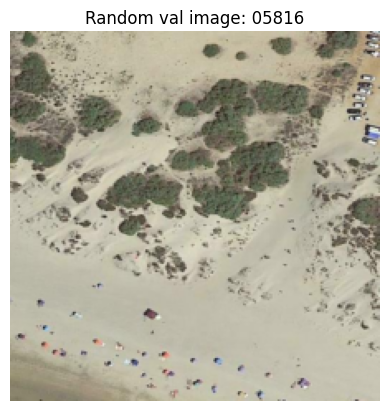

In [26]:
import os
import random
import math
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from audioldm import build_model, save_wave
from audioldm.ciap.models.image_encoder import ImageEncoder
from audioldm.ciap.models.audio_encoder import AudioEncoder
from audioldm.ciap.models.ciap_cond import CIAPCondStage
from audioldm.ciap.datasets.paired_image_audio_dataset import PairedImageAudioDataset

# Config + device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize CIAP encoders and load checkpoints (use your ckpt directory)
ckpt_dir = "/Users/luffy_sama/Desktop/Workspace/IE_643/AudioLDM/ckpt"
image_ckpt = os.path.join(ckpt_dir, "ciap_image_encoder_epoch110.pt")
audio_ckpt = os.path.join(ckpt_dir, "ciap_audio_encoder2.pt")

image_encoder = ImageEncoder(config["model"]["image_encoder"]).to(device)
audio_encoder = AudioEncoder(config["model"]["audio_encoder"]).to(device)

def load_mapped_state(model, ckpt_path, mapping_rules=None, device="cpu"):
    sd = torch.load(ckpt_path, map_location=device)
    # if saved is a full dict with extra keys, try to find a state_dict inside
    if isinstance(sd, dict) and any(k in sd for k in ("state_dict", "model_state_dict")):
        for key in ("state_dict", "model_state_dict"):
            if key in sd:
                sd = sd[key]
                break

    model_keys = set(model.state_dict().keys())
    new_sd = {}
    skipped = []
    for k, v in list(sd.items()):
        nk = k
        # apply simple replacement rules if provided
        if mapping_rules:
            for src, dst in mapping_rules.items():
                if nk.startswith(src):
                    nk = nk.replace(src, dst, 1)
        # common fallback: proj -> fc
        if nk not in model_keys and nk.startswith("proj."):
            nk = nk.replace("proj.", "fc.", 1)
        # drop layernorm keys if model has no matching ln*
        if nk in model_keys:
            new_sd[nk] = v
        else:
            skipped.append(k)

    # load with strict=False so we don't fail on missing keys
    load_res = model.load_state_dict(new_sd, strict=False)
    print(f"Loaded {ckpt_path}: missing_keys={len(load_res.missing_keys)}, unexpected_keys={len(load_res.unexpected_keys)}")
    if skipped:
        print(f"Skipped {len(skipped)} keys from checkpoint (first 10): {skipped[:10]}")
    return load_res

# try mapped load for image encoder
try:
    mapping = {"proj.": "fc.", "ln.": "ln."}  # proj->fc mapping; ln kept (will be skipped if model has no ln)
    res = load_mapped_state(image_encoder, image_ckpt, mapping_rules=mapping, device=device)
    if len(res.missing_keys) > 0:
        print("Warning: some keys missing after mapped load. You can inspect model.image_encoder and checkpoint to resolve.")
except Exception as e:
    print("Primary mapped load failed, attempting non-strict direct load:", e)
    try:
        image_encoder.load_state_dict(torch.load(image_ckpt, map_location=device), strict=False)
        print("Loaded image checkpoint with strict=False")
    except Exception as e2:
        raise RuntimeError(f"Failed to load image checkpoint: {e2}")

# load audio encoder if available (simple non-strict load)
if os.path.exists(audio_ckpt):
    try:
        audio_encoder.load_state_dict(torch.load(audio_ckpt, map_location=device), strict=False)
        print("Loaded audio encoder checkpoint (non-strict).")
    except Exception as e:
        print("Failed to load audio encoder checkpoint:", e)
else:
    print("Audio encoder checkpoint not found:", audio_ckpt)

image_encoder.eval()
audio_encoder.eval()
print("Loaded CIAP encoder checkpoints.")

audioldm.eval()

# Validation dataset (random single sample)
val_path = config.get("dataset", {}).get("val", {}).get("path", "/Users/luffy_sama/Desktop/Workspace/IE_643/AudioLDM/data/val")
img_ext = config.get("dataset", {}).get("val", {}).get("image_extension", ".png")
aud_ext = config.get("dataset", {}).get("val", {}).get("audio_extension", ".wav")

dataset = PairedImageAudioDataset(val_path, image_ext=img_ext, audio_ext=aud_ext)
if len(dataset) == 0:
    raise RuntimeError(f"No validation samples found at {val_path}")

rand_idx = random.randrange(len(dataset))
sample = dataset[rand_idx]   # returns (image, audio, image_path)
image, _, image_path = sample

# Ensure batch dim
if image.dim() == 3:
    image = image.unsqueeze(0)   # [1,C,H,W]

image = image.to(device)

# Build cond stage with CIAP encoders
cond = CIAPCondStage(image_encoder, audio_encoder, embed_dim=512, device=device)

with torch.no_grad():
    # encode image -> embedding (on same device as cond)
    img_emb = cond.encode(image)   # shape [B, D]
    print("Image embedding shape:", img_emb.shape)

    # sample latent from AudioLDM conditioned on image embedding (zero-shot)
    waveform_latent = audioldm.sample(cond=img_emb, batch_size=img_emb.shape[0])

    # decode to mel + waveform
    mel = audioldm.decode_first_stage(waveform_latent)
    waveform = audioldm.mel_spectrogram_to_waveform(mel)

    # crop to desired duration (optional)
    desired_seconds = 5
    sample_rate = 16000
    target_len = desired_seconds * sample_rate
    if waveform.shape[-1] > target_len:
        waveform = waveform[..., :target_len]

    # save
    image_name = os.path.basename(image_path).split(".")[0] if isinstance(image_path, str) else os.path.basename(image_path[0]).split(".")[0]
    zero_shot_name = image_name + "_ciap_zero_shot"
    #copy orignal audio from /data/val to ./output for comparison
    out_dir = "./output"
    import shutil
    orig_audio_path = os.path.join(val_path, image_name + aud_ext)
    shutil.copyfile(orig_audio_path, os.path.join(out_dir, image_name + aud_ext))

    os.makedirs(out_dir, exist_ok=True)
    save_wave(waveform, savepath=out_dir, name=zero_shot_name)
    print(f"Saved generated audio: {out_dir}/{zero_shot_name}.wav")

    # display image
    plt.imshow(image[0].permute(1,2,0).cpu().numpy())
    plt.title(f"Random val image: {image_name}")
    plt.axis("off")
    plt.show()